In [1]:
import pypsa, os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
plt.rc("figure", figsize=(10, 8))
import matplotlib as mpl
to_rgba = mpl.colors.colorConverter.to_rgba

In [2]:
from vresutils import Dict
from snakemake.rules import expand
import yaml
snakemake = Dict()
snakemake.wildcards = Dict(#cost=#'IRP2016-Apr2016',
                            costs='ambitions',
                            regions='9-supply',
                            resarea='redz',
                            ll='copt',
                            opts='LC',
                            attr='p_nom')

snakemake.input = Dict(network='../results/version-0.6/networks/solved_{costs}_{regions}_{resarea}_l{ll}_{opts}.nc'.format(**snakemake.wildcards),
                        supply_regions='../data/supply_regions/supply_regions_{regions}.shp'.format(**snakemake.wildcards),
                        resarea = "../data/bundle/REDZ_DEA_Unpublished_Draft_2015")
snakemake.output = (expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}.pdf',
                            **snakemake.wildcards) +
                    expand('../results/plots/{costs}_{regions}_{resarea}_l{ll}_{opts}_{attr}_ext.pdf',
                            **snakemake.wildcards))
snakemake.params = Dict(ext=['png'])
# with open('../config.yaml') as f:
#     snakemake.config = yaml.load(f)


import yaml
with open("../config.yaml", 'r') as stream:
    try:
        snakemake.config=yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

tech_costs = "../data/costs.xlsx"

In [3]:
n=pypsa.Network(snakemake.input.network)

INFO:pypsa.io:Imported network solved_ambitions_9-supply_redz_lcopt_LC.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [4]:
opts = snakemake.config['plotting']
line_colors = {'cur': "purple",
               'exp': to_rgba("red", 0.7)}
tech_colors = opts['tech_colors']

In [5]:
n.generators.p_nom_opt[n.generators.carrier=='onwind']

Generator
EASTERN CAPE onwind_2040      6007.937112
FREE STATE onwind_2040           9.479454
NORTH WEST onwind_2040       28244.533241
NORTHERN CAPE onwind_2040    31186.955979
WESTERN CAPE onwind_2040         0.467565
Name: p_nom_opt, dtype: float64

In [6]:
n.generators[['bus','carrier','p_nom_opt']].groupby(["bus","carrier"]).sum()

p_nom_opt
bus           carrier                      
EASTERN CAPE  CCGT              4450.511270
              OCGT              1002.957785
              load_shedding  1000000.000000
              nuclear              0.055876
              oil                335.000000
              onwind            6007.937112
              solar             9486.620824
FREE STATE    gas                425.000000
              load_shedding  1000000.000000
              onwind               9.479454
              solar            16633.967277
GAUTENG       CCGT              6095.407791
              OCGT              1007.343804
              coal              3040.078497
              load_shedding  1000000.000000
KZN           CCGT              5325.119154
              OCGT              1006.684420
              load_shedding  1000000.000000
              oil                670.000000
LIMPOPO       coal              7287.077754
              load_shedding  1000000.000000
MPUMALANGA    coal              8283.000000
              load_shedding  1000000.000000
NORTH WEST    load_shedding  1000000.000000
              onwind           28244.533241
              solar                4.934889
NORTHERN CAPE load_shedding  1000000.000000
              onwind           31186.955979
              solar            17095.550227
WESTERN CAPE  CCGT              4191.441800
              OCGT              1004.591813
              load_shedding  1000000.000000
              nuclear           1854.055893
              onwind               0.467565
              solar            10719.501853

In [7]:
bus_sizes = pd.concat(
    (
        n.generators.query('carrier != "load"')
        .groupby(["bus", "carrier"])
        .p_nom_opt.sum(),
        n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum(),
    )
)
line_widths_exp = n.lines.s_nom_opt
line_widths_cur = n.lines.s_nom_min
link_widths_exp = n.links.p_nom_opt
link_widths_cur = n.links.p_nom_min

In [8]:
attribute="p_nom"
linewidth_factor = opts["map"][attribute]["linewidth_factor"]
bus_size_factor = opts["map"][attribute]["bus_size_factor"]
flow = pd.Series(10, index=n.branches().index)

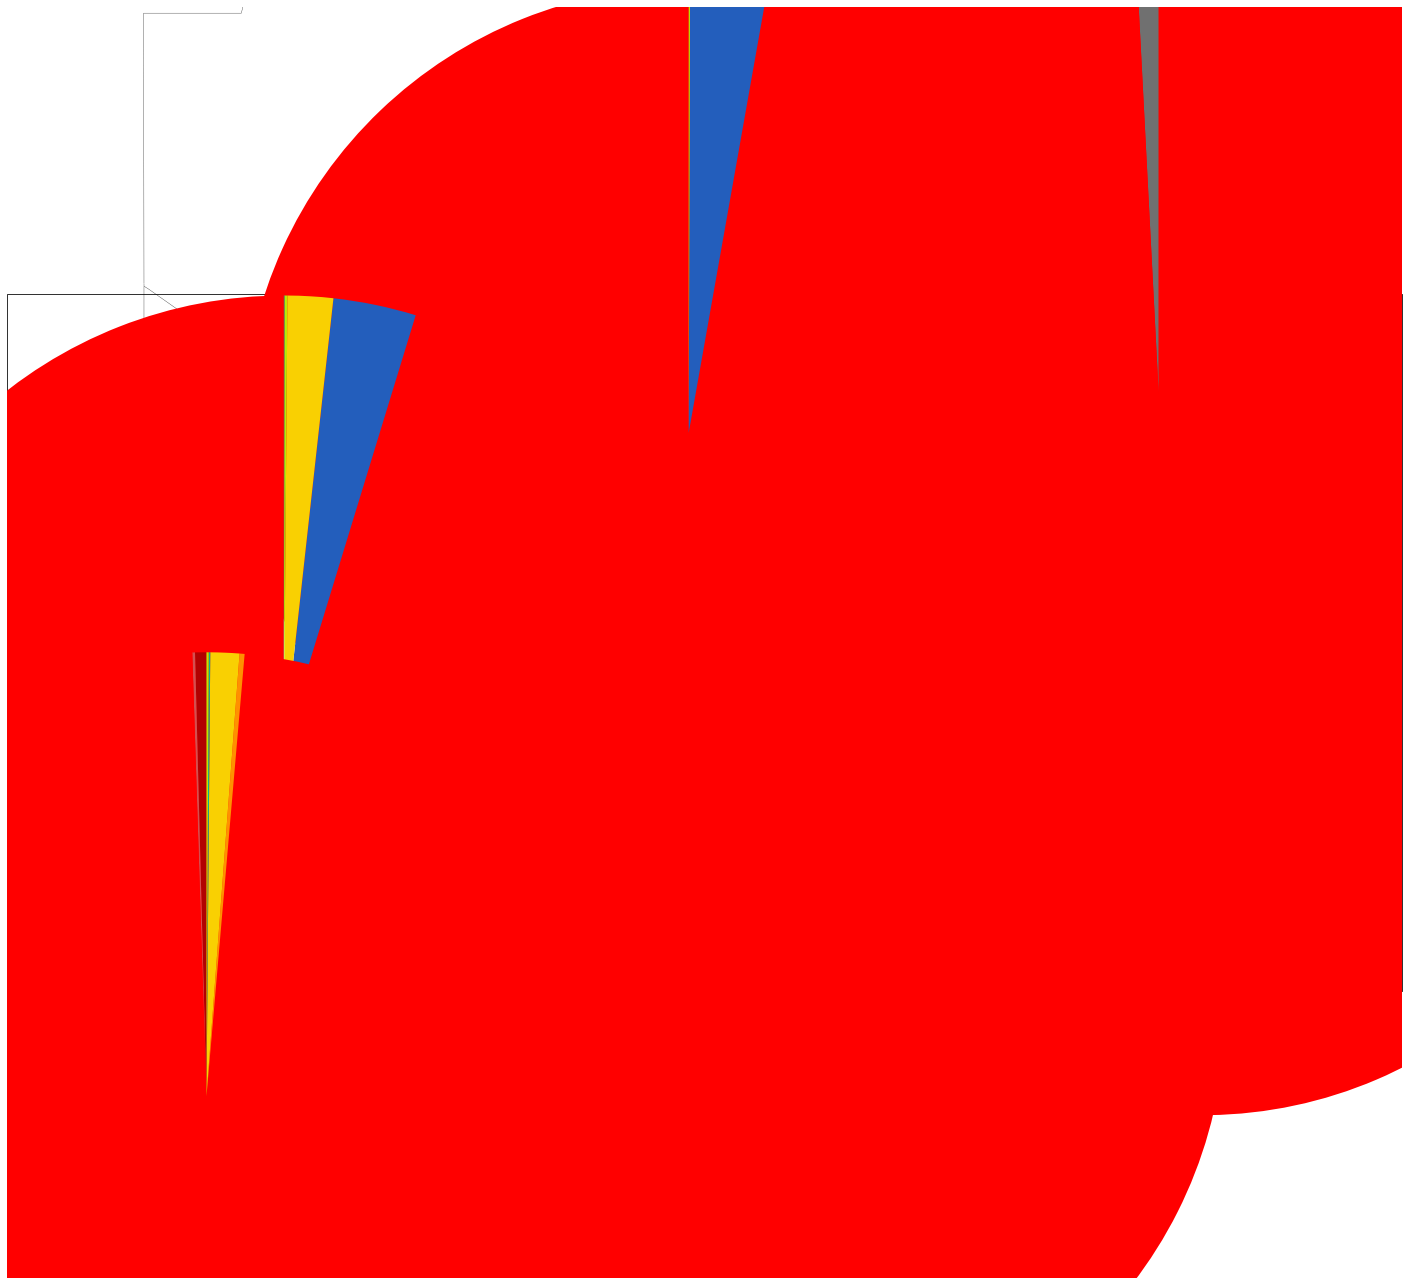

In [12]:
fig, ax = plt.subplots(
    figsize=[25,25], subplot_kw={"projection": ccrs.PlateCarree()}
)
n.generators=n.generators[n.generators.carrier!='load_shedding']
n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.2,
    flow="mean",
    line_widths=0.015,
    link_widths=1,
)
plt.show()

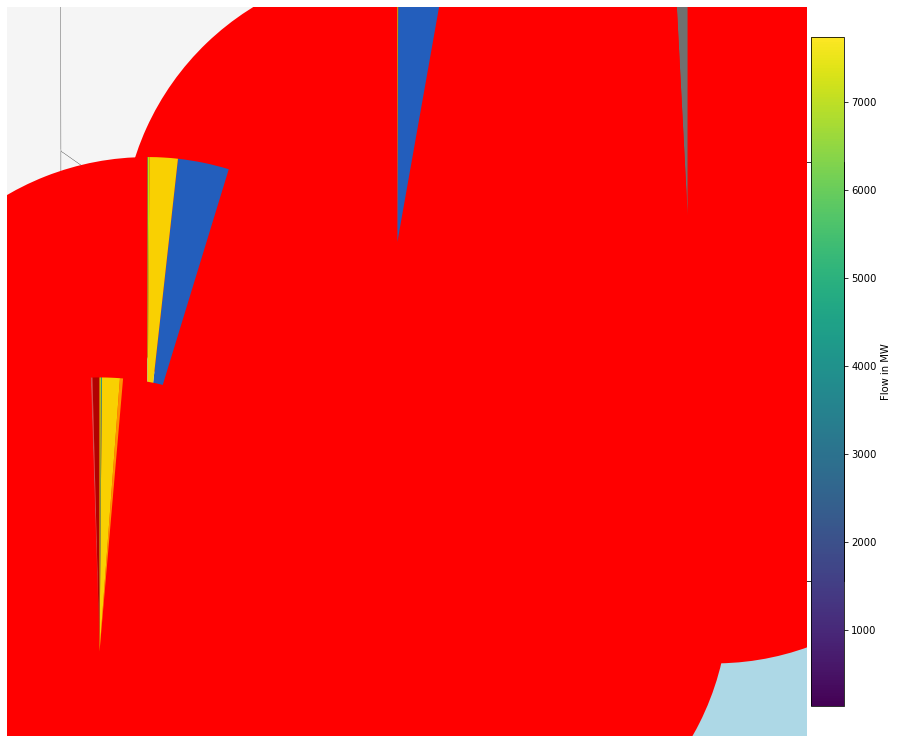

In [10]:
# Pandas series with MultiIndex
# links are not displayed for prettier output ('link_widths=0')
fig, ax = plt.subplots(
    figsize=[15,15], subplot_kw={"projection": ccrs.PlateCarree()}
)

collection = n.plot(
    bus_sizes=bus_sizes / bus_size_factor,
    bus_colors=tech_colors,
    margin=0.15,
    flow=flow,
    line_widths=0.5,
    link_widths=0,
    #projection=ccrs.EqualEarth(),
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)

plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [11]:
n.generators

,carrier,p_nom,build_year,min_stable,y,x,efficiency,marginal_cost,capital_cost,ramp_limit_up,...,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kendal,coal,3840.0,2040,0.5,-26.08805,28.96888,0.306305,362.587920,5.940000e+05,0.028125,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Kusile,coal,2880.0,2025,0.5,-25.54590,28.55020,0.366898,335.121233,4.700000e+06,0.150000,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaDry,coal,1833.0,2040,0.5,-27.09555,29.77055,0.306305,362.587622,5.940000e+05,0.055646,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
MajubaWet,coal,2010.0,2040,0.5,-27.09555,29.77055,0.327154,343.114704,5.940000e+05,0.056716,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Matimba,coal,3690.0,2040,0.5,-23.66777,27.61277,0.308907,360.013501,5.940000e+05,0.048780,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Medupi,coal,3597.0,2040,0.5,-23.42000,27.33000,0.366898,335.121606,4.700000e+06,0.120100,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Koeberg,nuclear,1854.0,2040,0.0,-33.67366,18.42811,0.324003,127.008862,9.680000e+05,NaN,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Municipal_Coal,coal,160.0,2040,0.5,-26.65800,28.11380,0.290980,249.505946,0.000000e+00,0.187500,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
Sasol_SSF,coal,600.0,2040,0.5,-26.50360,29.18030,0.290980,1069.505848,0.000000e+00,0.050000,...,False,0.0,0.0,0,0,1,0,NaN,1.0,1.0
